# Importing necessary packages and the data

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd

In [2]:
# imports the csv into the local notebook
df = pd.read_csv('real_estate_db.csv', encoding='latin-1')

# Cleaning the data

In [3]:
from scipy import stats

# drops duplicate rows and a nan column
df.drop_duplicates(subset=None, inplace=True)
df.drop('BLOCKID', axis=1, inplace=True)

# turns null characters into nan and drops all columns including nan
df = df.replace(r'^\s*$', np.nan, regex=True)
df.dropna(axis=0, inplace=True)

# drops outliers
# outliers are values that are beyond three std dev of the mean
for i in ['hs_degree','debt', 'rent_mean', 'hc_mortgage_mean', 'home_equity_second_mortgage', 'second_mortgage', 'home_equity', 'family_mean']:
  df = df[np.abs(stats.zscore(df[i])) < 3]

# samples 0.01 of the data
df_sampled = df.sample(frac=0.01)
df_sampled.head()

,UID,SUMLEVEL,COUNTYID,STATEID,state,state_ab,city,place,type,primary,...,female_age_mean,female_age_median,female_age_stdev,female_age_sample_weight,female_age_samples,pct_own,married,married_snp,separated,divorced
35885,288470,140,35,49,Utah,UT,Taylorsville,Taylorsville City,City,tract,...,33.96066,29.75000,22.31217,538.23982,2248.0,0.68270,0.61119,0.01280,0.00000,0.08558
13473,245964,140,91,18,Indiana,IN,Michigan City,Pottawattamie Park,City,tract,...,35.96763,33.25000,21.55015,300.30920,1308.0,0.56047,0.46643,0.00000,0.00000,0.15108
32756,282536,140,157,47,Tennessee,TN,Memphis,Memphis City,City,tract,...,40.85881,40.16667,24.04078,461.70429,1967.0,0.58522,0.46208,0.02121,0.01671,0.14075
34147,285152,140,187,48,Texas,TX,Schertz,Schertz City,Town,tract,...,37.54384,39.00000,22.52018,726.25875,2856.0,0.89092,0.76286,0.00727,0.00000,0.02517
36224,289067,140,59,51,Virginia,VA,Alexandria,Hybla Valley,Town,tract,...,44.21946,45.75000,24.66453,690.48400,3166.0,0.62602,0.59317,0.01854,0.01220,0.03805


# Heatmap

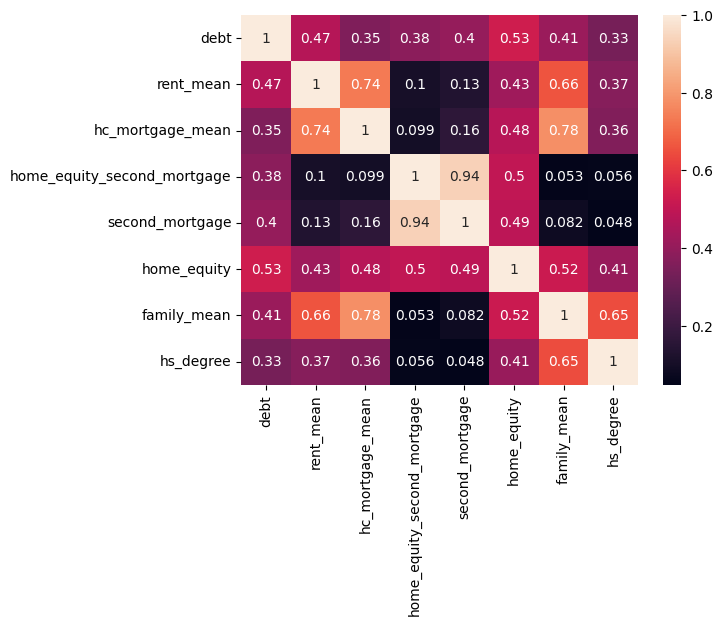

In [4]:
import seaborn as sb

data = df_sampled[['debt', 'rent_mean', 'hc_mortgage_mean', 'home_equity_second_mortgage', 'second_mortgage', 'home_equity', 'family_mean', 'hs_degree']]
dataplot=sb.heatmap(data.corr(), annot=True)

# Function to create a boolean from graduation rate

In [5]:
# function to check whether or not the average person is graduated
def check_condition(value, threshold):
    if value > threshold:
        return 'Yes'
    else:
        return 'No'

# uses function to check whether values are greater or lesser than the mean and
# writes to new column
hs_degree_mean = df_sampled['hs_degree'].mean()
df_sampled['avg_person_graduated'] = df_sampled['hs_degree'].apply(lambda x: check_condition(x, hs_degree_mean))

# Neural Network

In [6]:
# defines X and y datasets
data_no_hs_degree = df_sampled[['debt', 'rent_mean', 'hc_mortgage_mean', 'home_equity_second_mortgage', 'second_mortgage', 'home_equity', 'family_mean']]
X = data_no_hs_degree
y = df_sampled['hs_degree']

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# splits data into X and y training sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)

# scales X and y features for linear model
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense

# defines network model
model = Sequential()
model.add(Input(shape=(X_train.shape[1],)))
model.add(Dense(units=32, activation='relu'))
model.add(Dense(units=16, activation='tanh'))
model.add(Dense(units=1, activation='linear'))

In [9]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# optimizer
initial_learning_rate = 0.001  # learning rate
optimizer = Adam(learning_rate=initial_learning_rate)

# learning rate scheduler
def lr_scheduler(epoch):
    return initial_learning_rate * 0.95 ** epoch
lr_callback = LearningRateScheduler(lr_scheduler)

# mean percent error metric
def mean_percent_error(y_true, y_pred):
    mpe = tf.abs(tf.reduce_mean((y_true - y_pred) / y_true) * 100)
    return mpe

# trains model
model.compile(optimizer=optimizer, loss='mse', metrics=['mae', mean_percent_error])
model.fit(X_train, y_train, batch_size = 1, epochs = 100, callbacks=[lr_callback])

Epoch 1/100
279/279 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.2132 - mae: 0.3475 - mean_percent_error: 41.2278 - learning_rate: 0.0010
Epoch 2/100
279/279 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0233 - mae: 0.1252 - mean_percent_error: 14.8473 - learning_rate: 9.5000e-04
Epoch 3/100
279/279 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0158 - mae: 0.0974 - mean_percent_error: 11.8860 - learning_rate: 9.0250e-04
Epoch 4/100
279/279 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0110 - mae: 0.0835 - mean_percent_error: 10.0819 - learning_rate: 8.5737e-04
Epoch 5/100
279/279 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0110 - mae: 0.0834 - mean_percent_error: 10.3630 - learning_rate: 8.1451e-04
Epoch 6/100
279/279 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0065 - mae: 0.0597 - mean_percent_error: 7.0521 - learning_rate: 7.7378e-04
Epoch 7/100
279/279 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0079 - mae: 0.0707 - mean_percent_error: 8.4122 - learning_rate: 7.3509e-04
Epoch 8/100
279/279 ━━━━━━

In [10]:
# performs predictions
y_pred = model.predict(X_test)

r2 = r2_score(y_test, y_pred)
print(f"R-squared: {r2:.2f}")

mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error: {mae:.2f}")

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Root Mean Squared Error: {rmse:.2f}")

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
R-squared: 0.20
Mean Absolute Error: 0.06
Root Mean Squared Error: 0.08


# Decision Tree Classification

In [11]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# find X and y
X = df_sampled[['debt', 'family_mean']]
y = df_sampled['avg_person_graduated'].apply(lambda x: 1 if x=='Yes' else 0)

# separates data into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# creates the decision tree classifier
clf = DecisionTreeClassifier(random_state=42)
clf.fit(X_train, y_train)

# makes predictions
y_pred = clf.predict(X_test)

# accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

# classification report
report = classification_report(y_test, y_pred)
print("Classification Report:")
print(report)

Accuracy: 0.80
Confusion Matrix:
[[22  7]
 [ 7 34]]
Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.76      0.76        29
           1       0.83      0.83      0.83        41

    accuracy                           0.80        70
   macro avg       0.79      0.79      0.79        70
weighted avg       0.80      0.80      0.80        70



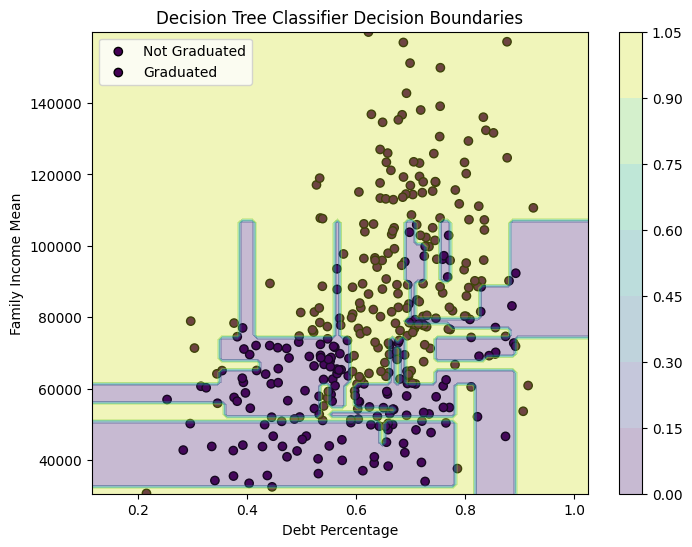

In [12]:
import matplotlib.pyplot as plt

# plots the decision tree
plt.figure(figsize=(8, 6))
plt.scatter(X[y == 0]['debt'], X[y == 0]['family_mean'], c=y[y == 0], cmap='viridis', edgecolors='k', label='Not Graduated')
plt.scatter(X[y == 1]['debt'], X[y == 1]['family_mean'], c=y[y == 1], cmap='viridis', edgecolors='k', label='Graduated')
xx, yy = np.meshgrid(np.linspace(X['debt'].min() - 0.1, X['debt'].max() + 0.1, 100), np.linspace(X['family_mean'].min() - 100, X['family_mean'].max() + 100, 100))
grid_df = pd.DataFrame(np.c_[xx.ravel(), yy.ravel()], columns=X.columns)
Z = clf.predict(grid_df).reshape(xx.shape)
plt.contourf(xx, yy, Z, alpha=0.3, cmap='viridis')
plt.xlabel('Debt Percentage')
plt.ylabel('Family Income Mean')
plt.title('Decision Tree Classifier Decision Boundaries')
plt.colorbar()
plt.legend()
plt.show()

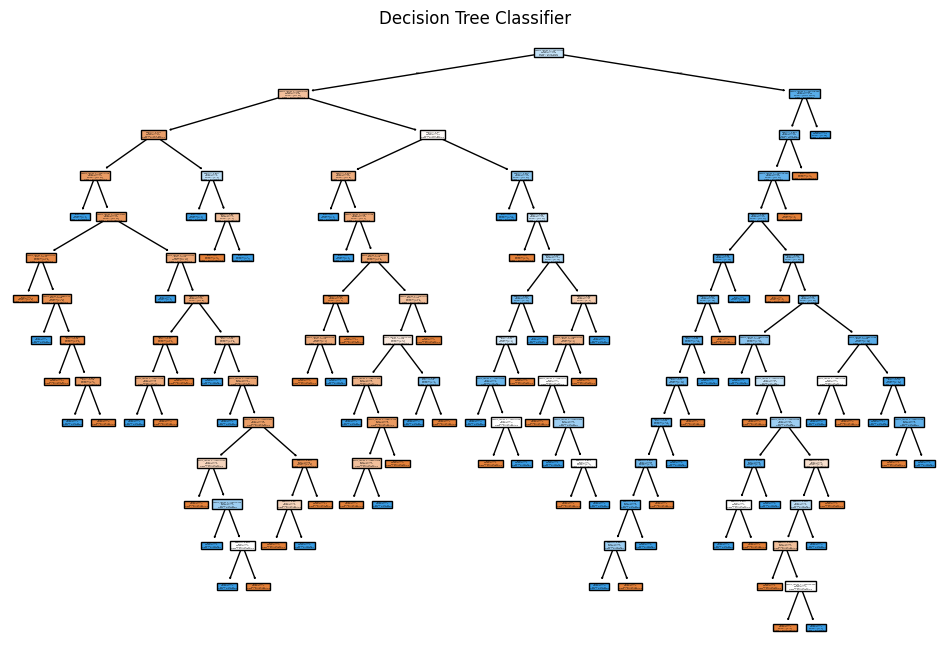

In [13]:
from sklearn.tree import plot_tree

# plots the decision tree
plt.figure(figsize=(12, 8))
plot_tree(clf, filled=True, feature_names=X.columns, class_names=['Not Graduated', 'Graduated'])
plt.title('Decision Tree Classifier')
plt.show()

# Random Forest Classification

In [14]:
from sklearn.ensemble import RandomForestClassifier

# identify the X and y
X = df_sampled[['debt', 'family_mean']]
y = df_sampled['avg_person_graduated'].apply(lambda x: 1 if x=='Yes' else 0)

# split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# creates the random forest classifier
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

# makes predictions
y_pred = clf.predict(X_test)

# accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

# classification report
report = classification_report(y_test, y_pred)
print("Classification Report:")
print(report)

Accuracy: 0.84
Confusion Matrix:
[[24  5]
 [ 6 35]]
Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.83      0.81        29
           1       0.88      0.85      0.86        41

    accuracy                           0.84        70
   macro avg       0.84      0.84      0.84        70
weighted avg       0.84      0.84      0.84        70



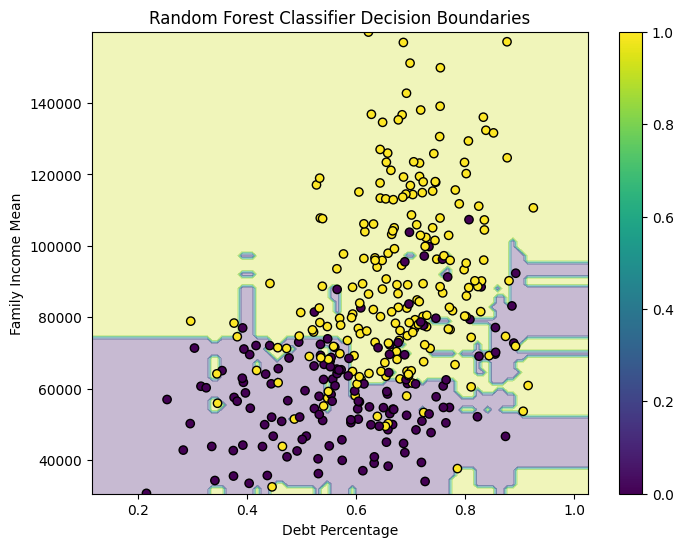

In [15]:
# plots boundaries
plt.figure(figsize=(8, 6))
xx, yy = np.meshgrid(np.linspace(X.values[:, 0].min() - 0.1, X.values[:, 0].max() + 0.1, 100), np.linspace(X.values[:, 1].min() - 100, X.values[:, 1].max() + 100, 100))
grid_df = pd.DataFrame(np.c_[xx.ravel(), yy.ravel()], columns=X.columns)
Z = clf.predict(grid_df).reshape(xx.shape)
plt.contourf(xx, yy, Z, alpha=0.3, cmap='viridis')
plt.scatter(X.values[:, 0], X.values[:, 1], c=y, cmap='viridis', edgecolors='k')
plt.xlabel('Debt Percentage')
plt.ylabel('Family Income Mean')
plt.title('Random Forest Classifier Decision Boundaries')
plt.colorbar()
plt.show()

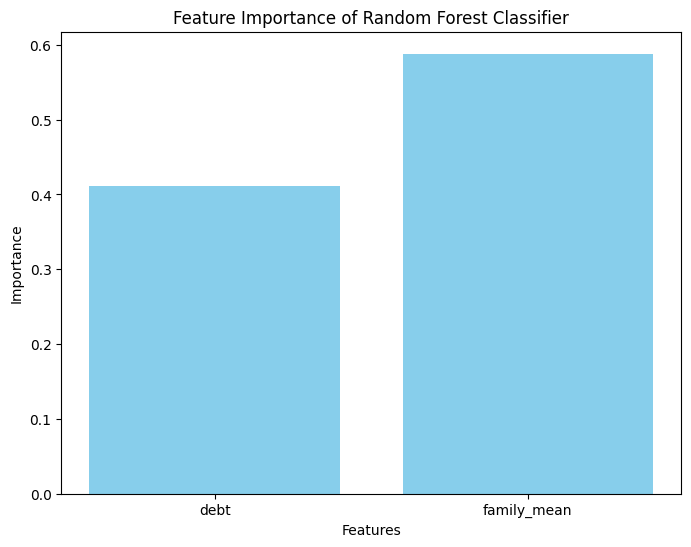

In [16]:
# plots features
plt.figure(figsize=(8, 6))
plt.bar(X.columns, clf.feature_importances_, color='skyblue')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importance of Random Forest Classifier')
plt.show()

# Interactive US Map

In [17]:
import plotly.express as px

avg_grad_rates = df.groupby('state_ab')['hs_degree'].mean().reset_index()
fig = px.choropleth(avg_grad_rates, locations='state_ab', locationmode='USA-states', color='hs_degree', hover_name='state_ab', color_continuous_scale='blues', title='Average High School Graduation Rates by State')
fig.update_layout(geo_scope='usa')
fig.show()

# Scatterplot of Degree Percentage versus Debt Percentage

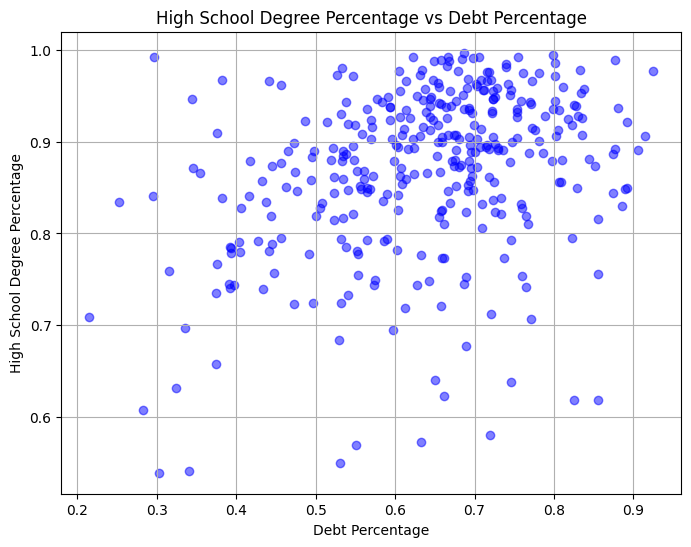

In [18]:
plt.figure(figsize=(8, 6))
plt.scatter(df_sampled['debt'], df_sampled['hs_degree'], color='b', alpha=0.5)
plt.title('High School Degree Percentage vs Debt Percentage')
plt.xlabel('Debt Percentage')
plt.ylabel('High School Degree Percentage')
plt.grid(True)
plt.show()

# Line Chart of Graduation Rate versus Debt Percentage

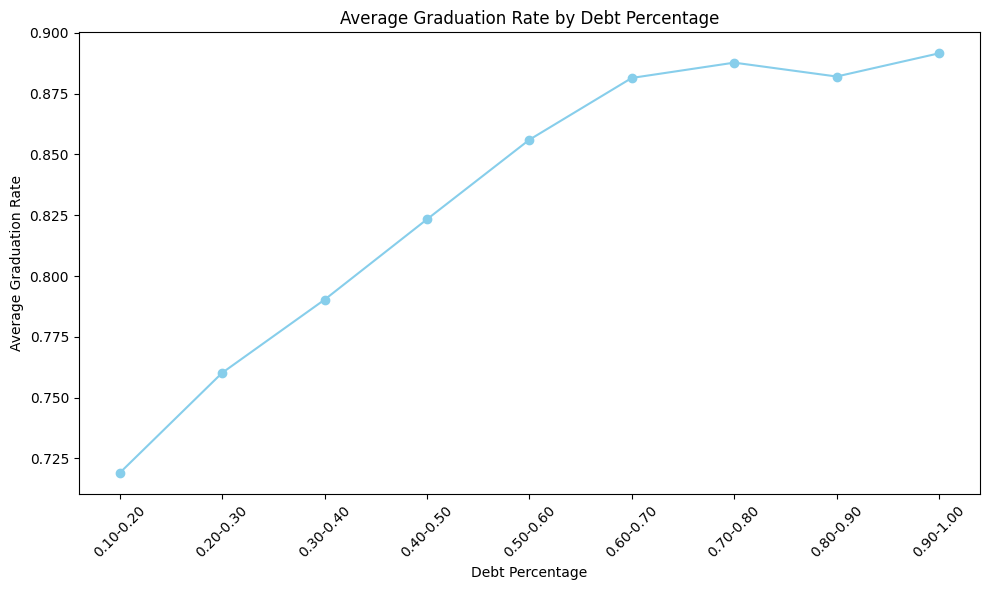

In [19]:
bins = np.linspace(0, 1, 11)
labels = [f'{bins[i]:.2f}-{bins[i+1]:.2f}' for i in range(len(bins)-1)]
df['debt_binned'] = pd.cut(df['debt'], bins=bins, labels=labels, right=False)
avg_graduation_rate = df.groupby('debt_binned', observed=True)['hs_degree'].mean()
plt.figure(figsize=(10, 6))
plt.plot(avg_graduation_rate.index, avg_graduation_rate.values, marker='o', linestyle='-', color='skyblue')
plt.xlabel('Debt Percentage')
plt.ylabel('Average Graduation Rate')
plt.title('Average Graduation Rate by Debt Percentage')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Pair Plot of Rent Mean versus Graduation Rate

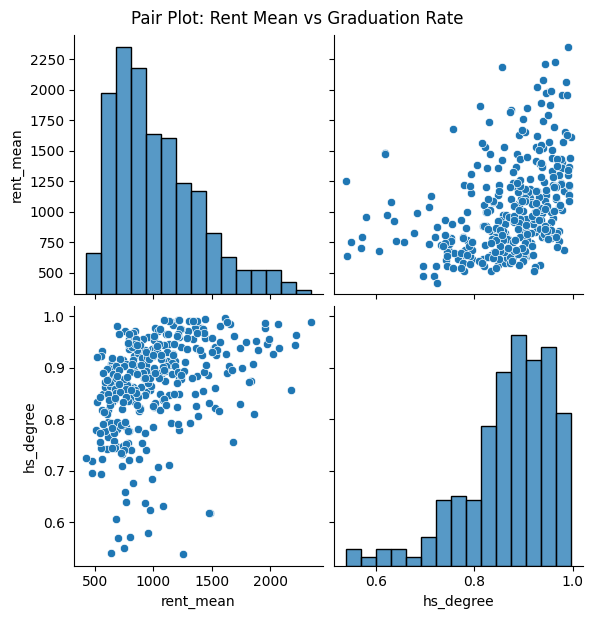

In [20]:
sb.pairplot(df_sampled[['rent_mean', 'hs_degree']], height=3)
plt.suptitle('Pair Plot: Rent Mean vs Graduation Rate', y=1.02)
plt.show()

# Joint Plot of Mortgage Mean versus Graduation Rate

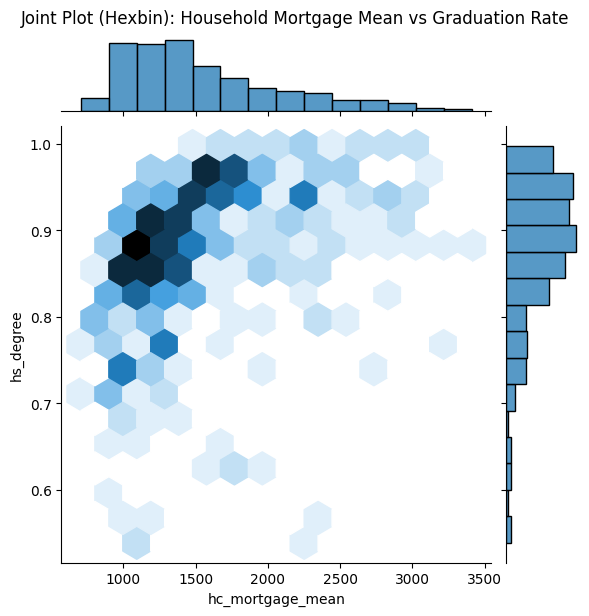

In [21]:
sb.jointplot(x='hc_mortgage_mean', y='hs_degree', data=df_sampled, kind='hex', height=6)
plt.suptitle('Joint Plot (Hexbin): Household Mortgage Mean vs Graduation Rate', y=1.02)
plt.show()

# Scatter Plot of Family Income Mean versus Graduation Rate

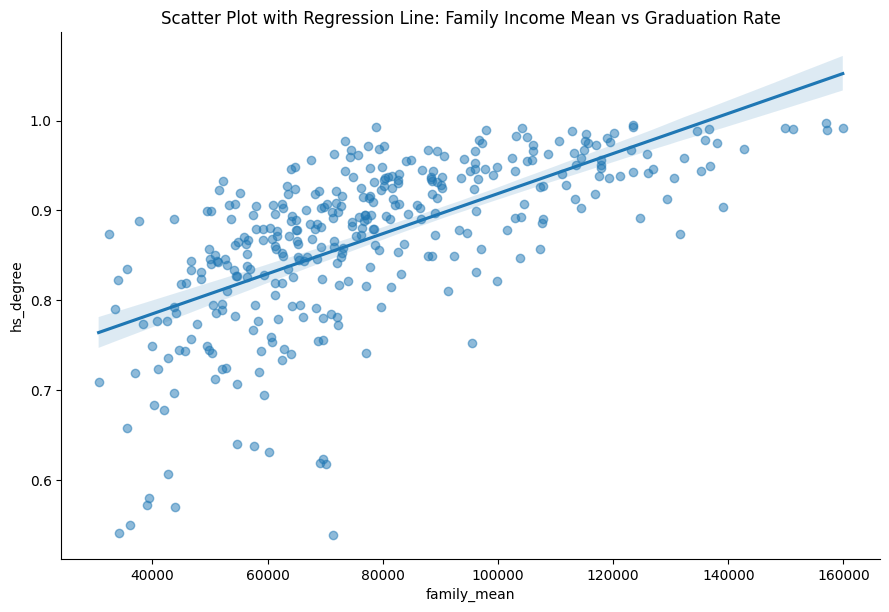

In [22]:
sb.lmplot(x='family_mean', y='hs_degree', data=df_sampled, height=6, aspect=1.5, scatter_kws={'alpha':0.5})
plt.title('Scatter Plot with Regression Line: Family Income Mean vs Graduation Rate')
plt.show()